## Description

This notebook uses BLIP-2, a state-of-the-art vision-language model by Salesforce, to generate descriptive text annotations (captions) of real images locally. These annotations can be used as downstream prompts for input into text-to-image diffusion models, to generate new synthetic image datasets. An intermediary large language model (LLM) may be used to format and clean/improve the quality of annotations created before they are used for diffusion input.

HuggingFace docs: https://huggingface.co/docs/transformers/main/en/model_doc/blip_2.

## Set-up environment

First, follow the set up instructions in (make sure you have finished running 'python download_data.py')

Compute advisory: Recommended to run in a GPU environment with high RAM.

In [1]:
%%time
from bitmind.image_dataset import ImageDataset
from bitmind.constants import DATASET_META
import numpy as np
import random

import torch
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BlipProcessor
# from transformers import pipeline, BitsAndBytesConfig
# from transformers import AutoModelForCausalLM, AutoTokenizer

/root/miniconda3/envs/bitmind/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-02 22:04:24.101601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 22:04:24.121219: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 22:04:24.121262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 22:04:24.134667: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow bin

CPU times: user 5.6 s, sys: 1.73 s, total: 7.33 s
Wall time: 4.69 s


### Load finetuned BLIP-2 and processor

We can instantiate the model and its corresponding processor from the [hub](https://huggingface.co/models?other=blip-2). Here we load a BLIP-2 checkpoint that leverages the pre-trained OPT model by Meta AI, which as 2.7 billion parameters.

In [2]:
%%time
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b-coco")
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b-coco", torch_dtype=torch.float16) 
model.to(device)

Loading checkpoint shards: 100%|████████████████████████| 2/2 [00:24<00:00, 12.13s/it]


CPU times: user 38.4 s, sys: 38.5 s, total: 1min 16s
Wall time: 46.5 s


Blip2ForConditionalGeneration(
  (vision_model): Blip2VisionModel(
    (embeddings): Blip2VisionEmbeddings(
      (patch_embedding): Conv2d(3, 1408, kernel_size=(14, 14), stride=(14, 14))
    )
    (encoder): Blip2Encoder(
      (layers): ModuleList(
        (0-38): 39 x Blip2EncoderLayer(
          (self_attn): Blip2Attention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=1408, out_features=4224, bias=True)
            (projection): Linear(in_features=1408, out_features=1408, bias=True)
          )
          (layer_norm1): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
          (mlp): Blip2MLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1408, out_features=6144, bias=True)
            (fc2): Linear(in_features=6144, out_features=1408, bias=True)
          )
          (layer_norm2): LayerNorm((1408,), eps=1e-06, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((

### Load Real Image Datasets

In [3]:
%%time
print("Loading real datasets")
real_image_datasets = [
    ImageDataset(ds['path'], 'test', ds.get('name', None), ds['create_splits'])
    for ds in DATASET_META['real']
]
real_image_datasets

Loading real datasets
CPU times: user 3.09 s, sys: 8.04 s, total: 11.1 s
Wall time: 23 s


#### Display random sample image from real image datasets

{'image': <PIL.Image.Image image mode=RGB size=350x263 at 0x7F27EB0E7370>, 'id': 'https://farm1.staticflickr.com/8511/8495083339_7278124591_o.jpg'}


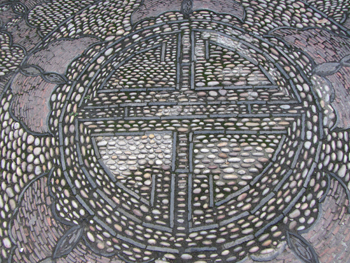

In [4]:
# select a dataset at random
real_dataset = real_image_datasets[np.random.randint(0, len(real_image_datasets))]
# select a dict containing a sample image at random
sample = real_dataset.sample(k=1)[0][0]
image = sample['image']
print(sample)
image

## Prompt-Based Text Annotation

Pipeline for generating text annotations describing each image in real image datasets. 

In [5]:
prompts = [
    "A picture of",
    "The setting is",
    "The foreground is",
    "the background is",
    "The color(s) are",
    # "The texture(s) are",
    # "The emotion/mood is",
    # "The image medium is",
    # "The image style is"
]

In [6]:
def generate_description(image, verbose=False):
    description = ""
    for i, prompt in enumerate(prompts):
        # Append prompt to description to build context history
        description += prompt + ' '
        inputs = processor(image, text=description, return_tensors="pt").to(device, torch.float16)
        generated_ids = model.generate(**inputs, max_new_tokens=20)
        answer = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
        if verbose:
            print(str(i) + '. Prompt:',prompt)
            print(str(i)+'. Answer:',answer)
        if len(answer) > 0:
            # Append answer to description to build context history
            description += answer + '.'
        else:
            description -= (prompt + ' ')
    return description

#### To-do

-Measure annotation generation latency

-Improve latency by changing annotation method, implementing multiprocessing, or ensure efficient gpu usage for prompting BLIP-2 at scale

-Annotation storage to local file

-Diff checking between local file and annotations in notebook instance memory

##### Populate a nested dictionary with image annotations for all datasets

Highest dictionary dataset level: {Keys = HuggingFace dataset path : Values = Sub dictionary}

Sub dictionary image level: {Keys = image id : Values = string text annotations}

In [7]:
annotations_dict = {}

In [8]:
%%time
for i, dataset in enumerate(real_image_datasets):
    annotations_dict[dataset.huggingface_dataset_path] = {}
    print(dataset.huggingface_dataset_path + ' Dataset (' + str(i+1) + ' of ' + str(len(real_image_datasets)) + '):')
    for j, image_dict in enumerate(dataset):
        if image_dict['image'] is not None:
            image = image_dict['image']
            annotations = generate_description(image)
            annotations_dict[dataset.huggingface_dataset_path][image_dict['id']] = annotations
            print('Image: ' + str(j))
            print(annotations)
            break
        break

dalle-mini/open-images Dataset (1 of 3):
merkol/ffhq-256 Dataset (2 of 3):


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `ma

Image: 0
A picture of a woman talking on a cell phone.The setting is outdoors.The foreground is blurred.The background is a white wall.The woman is wearing a black jacket.The woman is.the background is a white wall.The woman is wearing a black jacket.The woman is talking on a cell phone.The color(s) are black, white, and gray.The woman is talking on a cell phone.The woman is talking.
saitsharipov/CelebA-HQ Dataset (3 of 3):


Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `ma

Image: 0
A picture of a woman with a short hairstyle and earrings.The setting is a red carpet event.The foreground is a wall.The background is a black background.The woman is smiling.The woman is wearing a.the background is a black background.The woman is smiling.The woman is wearing a black dress.The woman is.The color(s) are black.The woman is smiling.The woman is wearing earrings.The woman is wearing a black.
CPU times: user 51.7 s, sys: 681 ms, total: 52.4 s
Wall time: 52.3 s


In [9]:
annotations_dict

{'dalle-mini/open-images': {},
 'merkol/ffhq-256': {0: 'A picture of a woman talking on a cell phone.The setting is outdoors.The foreground is blurred.The background is a white wall.The woman is wearing a black jacket.The woman is.the background is a white wall.The woman is wearing a black jacket.The woman is talking on a cell phone.The color(s) are black, white, and gray.The woman is talking on a cell phone.The woman is talking.'},
 'saitsharipov/CelebA-HQ': {0: 'A picture of a woman with a short hairstyle and earrings.The setting is a red carpet event.The foreground is a wall.The background is a black background.The woman is smiling.The woman is wearing a.the background is a black background.The woman is smiling.The woman is wearing a black dress.The woman is.The color(s) are black.The woman is smiling.The woman is wearing earrings.The woman is wearing a black.'}}